In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import jax.numpy as jnp
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import numpy as np
import jax.numpy as jnp

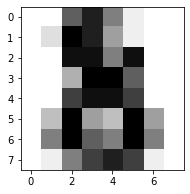

In [64]:
digits = datasets.load_digits()
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

Number of digits in the dataset: 1797
Class distribution: {0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}


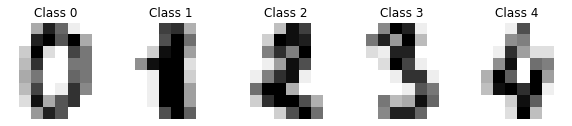

In [65]:
# 1. Count the number of digits
num_digits = len(digits.images)
print(f"Number of digits in the dataset: {num_digits}")

# Count the distribution of each class
unique, counts = np.unique(digits.target, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

# 2. View some digits from the classes 0, 1, 2, 3, 4
fig, axs = plt.subplots(1, 5, figsize=(10, 3))
classes_to_view = [0, 1, 2, 3, 4]
for i, cls in enumerate(classes_to_view):
    # Get the first image of each class
    idx = np.where(digits.target == cls)[0][0]
    axs[i].imshow(digits.images[idx], cmap=plt.cm.gray_r, interpolation="nearest")
    axs[i].set_title(f"Class {cls}")
    axs[i].axis("off")

plt.show()

## Filtering only few classes

In [66]:
classes_to_keep = [0, 1, 3, 4]
indices_to_keep = np.isin(digits.target, classes_to_keep)

# We first normalise all the images
images = digits.images / 16.0

filtered_images = images[indices_to_keep]
filtered_labels = digits.target[indices_to_keep]

# Print the number of images and class distribution in the filtered dataset
num_filtered_images = len(filtered_images)
print(f"Number of filtered images: {num_filtered_images}")

unique_filtered, counts_filtered = np.unique(filtered_labels, return_counts=True)
filtered_class_distribution = dict(zip(unique_filtered, counts_filtered))
print("Filtered class distribution:", filtered_class_distribution)
print(f"filtered images shape: {filtered_images.shape}")
print(f"filtered labels shape: {filtered_labels.shape}")

Number of filtered images: 724
Filtered class distribution: {0: 178, 1: 182, 3: 183, 4: 181}
filtered images shape: (724, 8, 8)
filtered labels shape: (724,)


In [67]:
X = filtered_images.reshape(-1, 8, 8, 1)
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(filtered_labels)

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print(
    "Class mapping:",
    dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))),
)

X shape: (724, 8, 8, 1)
Y shape: (724,)
Class mapping: {0: 0, 1: 1, 3: 2, 4: 3}


In [68]:
print(X.shape)
print(Y.shape)

(724, 8, 8, 1)
(724,)


In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y,
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (579, 8, 8, 1)
X_test shape: (145, 8, 8, 1)
Y_train shape: (579,)
Y_test shape: (145,)


## Utilities for rotations

In [70]:
def inverse_grid_number(n, number):
    if 1 <= number <= n**2:
        row_index = (number - 1) // n + 1
        column_index = (number - 1) % n + 1
        return row_index, column_index
    else:
        raise ValueError("Number must be between 1 and n^2 inclusive.")


def grid_number(n, a, b):
    if 1 <= a <= n and 1 <= b <= n:
        return (a - 1) * n + b
    else:
        raise ValueError("Row and column indices must be between 1 and n inclusive.")


def reflection_grid(n, coordinates):
    a, b = coordinates
    reflected_b = n - b + 1
    return a, reflected_b


def rotation_grid(n, coordinates):
    a, b = coordinates
    rotated_a = n - b + 1
    rotated_b = a
    return rotated_a, rotated_b


def rotate(n, number):
    (a, b) = inverse_grid_number(n, number)
    (new_a, new_b) = rotation_grid(n, (a, b))
    return grid_number(n, new_a, new_b)


def reflect(n, number):
    (a, b) = inverse_grid_number(n, number)
    (new_a, new_b) = reflection_grid(n, (a, b))
    return grid_number(n, new_a, new_b)


def generate_rotation_matrix(n):
    # Define the size of the matrix
    matrix_size = n**2

    # Initialize a matrix with zeros
    rotation_matrix = jnp.zeros((matrix_size, matrix_size), dtype=int)

    # Set 1 at the specified positions for each column
    for m in range(1, matrix_size + 1):
        rotated_position = rotate(n, m)
        rotation_matrix = rotation_matrix.at[rotated_position - 1, m - 1].set(
            1
        )  # Adjust for 0-based indexing

    return rotation_matrix


def generate_reflection_matrix(n):
    # Define the size of the matrix
    matrix_size = n**2

    # Initialize a matrix with zeros
    reflection_matrix = jnp.zeros((matrix_size, matrix_size), dtype=int)

    # Set 1 at the specified positions for each column
    for m in range(1, matrix_size + 1):
        reflected_position = reflect(n, m)
        reflection_matrix = reflection_matrix.at[reflected_position - 1, m - 1].set(
            1
        )  # Adjust for 0-based indexing

    return reflection_matrix


def generate_d4_matrices(n):
    """Outputs n^2 by n^2 matrices"""
    # Get rotation and reflection matrices
    R = generate_rotation_matrix(n)
    S = generate_reflection_matrix(n)

    # Calculate R^2, R^3, SR, SR^2, SR^3
    R2 = jnp.dot(R, R)
    R3 = jnp.dot(R2, R)
    SR = jnp.dot(S, R)
    SR2 = jnp.dot(S, R2)
    SR3 = jnp.dot(S, R3)

    # Generate D4 matrices
    D4_matrices = [jnp.eye(n**2), R, R2, R3, S, SR, SR2, SR3]

    return D4_matrices

In [71]:
def apply_transformation(image, transformation_matrix, n):
    flat_image = image.flatten()
    transformed_flat_image = jnp.dot(transformation_matrix, flat_image)
    return transformed_flat_image.reshape((n, n))


def apply_transformation_tf(image, matrix, n):
    flat_image = tf.reshape(image, [n**2])
    transformed_flat_image = tf.linalg.matvec(matrix, flat_image)
    transformed_image = tf.reshape(transformed_flat_image, [n, n, 1])
    return transformed_image

## Augmenting the dataset

In [72]:
# Generate D4 rotation matrices for 8x8 images
n = 8
d4_matrices = generate_d4_matrices(n)
tf_d4_matrices = [tf.convert_to_tensor(matrix, dtype=tf.float32) for matrix in d4_matrices]
# Create augmented dataset
augmented_images = []
augmented_labels = []

print(len(filtered_images))

for img, lbl in zip(filtered_images, filtered_labels):
    for matrix in d4_matrices:
        transformed_image = apply_transformation(img, matrix, 8)
        augmented_images.append(transformed_image)
        augmented_labels.append(lbl)


augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"augmented images shape: {augmented_images.shape}")
print(f"aumented labels shape: {augmented_labels.shape}")

# Print the number of images and class distribution in the augmented dataset
num_augmented_images = len(augmented_images)
print(f"Number of augmented images: {num_augmented_images}")

unique_augmented, counts_augmented = np.unique(augmented_labels, return_counts=True)
augmented_class_distribution = dict(zip(unique_augmented, counts_augmented))
print("Augmented class distribution:", augmented_class_distribution)

724
augmented images shape: (5792, 8, 8)
aumented labels shape: (5792,)
Number of augmented images: 5792
Augmented class distribution: {0: 1424, 1: 1456, 3: 1464, 4: 1448}


In [73]:
augmented_images_reshaped = augmented_images.reshape(-1, 8, 8, 1)
print(augmented_images_reshaped.shape)
print(augmented_labels.shape)
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test_split(
    augmented_images_reshaped,
    augmented_labels,
    test_size=0.2,
    random_state=42,
    stratify=augmented_labels,
)

(5792, 8, 8, 1)
(5792,)


In [74]:
def apply_transformation_batch(inputs, matrix):
    transformed = tf.map_fn(
        lambda x: apply_transformation_tf(x, matrix, 8),
        inputs,
        # fn_output_signature=tf.float32,
    )
    return transformed

In [75]:
class CustomConvLayer(layers.Layer):
    def __init__(self, kernel_size):
        super(CustomConvLayer, self).__init__()
        self.kernel_size = kernel_size
        self.kernel = self.add_weight(
            shape=(kernel_size, kernel_size, 1, 1),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, inputs):
        batch_size, height, width, channels = (
            tf.shape(inputs)[0],
            inputs.shape[1],
            inputs.shape[2],
            inputs.shape[3],
        )
        convolved_results = []

        for matrix in tf_d4_matrices:
            transformed_inputs = apply_transformation_batch(inputs, matrix)
            convolved = tf.nn.conv2d(
                transformed_inputs, self.kernel, strides=[1, 1, 1, 1], padding="SAME"
            )
            convolved_results.append(convolved)

        convolved_average = tf.reduce_mean(tf.stack(convolved_results), axis=0)
        return convolved_average


class CustomPoolingLayer(layers.Layer):
    def __init__(self, pool_size):
        super(CustomPoolingLayer, self).__init__()
        self.pool_size = pool_size

    def call(self, inputs):
        res = tf.nn.avg_pool(
            inputs,
            ksize=[1, self.pool_size[0], self.pool_size[1], 1],
            strides=[1, self.pool_size[0], self.pool_size[1], 1],
            padding="VALID",
        )
        return res

In [76]:
kernel_size = 7

model = models.Sequential(
    [
        CustomConvLayer(kernel_size=kernel_size),
        CustomPoolingLayer(pool_size=(4, 4)),
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.fit(X_train, Y_train, epochs=50, batch_size=32)
print("Model training complete.")
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_acc)

# Fitting to augmented data
aug_model = models.Sequential(
    [
        CustomConvLayer(kernel_size=kernel_size),
        CustomPoolingLayer(pool_size=(4, 4)),
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)
# print("FITTING TO AUGMENTED DATA-------------------")
# aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# aug_model.fit(X_train_aug, Y_train_aug, epochs=10, batch_size=32)
# print("Model training complete.")
# test_loss, test_acc = aug_model.evaluate(X_test_aug, Y_test_aug)
# print("Test accuracy:", test_acc)

Epoch 1/50
19/19 [==============================] - 2s 12ms/step - loss: 1.3898 - accuracy: 0.2280
Epoch 2/50
19/19 [==============================] - 0s 11ms/step - loss: 1.3777 - accuracy: 0.2504
Epoch 3/50
19/19 [==============================] - 0s 13ms/step - loss: 1.3727 - accuracy: 0.1986
Epoch 4/50
19/19 [==============================] - 0s 12ms/step - loss: 1.3680 - accuracy: 0.2090
Epoch 5/50
19/19 [==============================] - 0s 18ms/step - loss: 1.3623 - accuracy: 0.2539
Epoch 6/50
19/19 [==============================] - 0s 20ms/step - loss: 1.3581 - accuracy: 0.2556
Epoch 7/50
19/19 [==============================] - 0s 14ms/step - loss: 1.3521 - accuracy: 0.2729
Epoch 8/50
19/19 [==============================] - 0s 14ms/step - loss: 1.3445 - accuracy: 0.2573
Epoch 9/50
19/19 [==============================] - 0s 13ms/step - loss: 1.3381 - accuracy: 0.2573
Epoch 10/50
19/19 [==============================] - 0s 12ms/step - loss: 1.3291 - accuracy: 0.2556
Epoch 11/

In [77]:
def create_circulant_matrix(kernel, image_size=8):
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2

    circ_matrix_size = image_size * image_size
    circ_matrix = np.zeros((circ_matrix_size, circ_matrix_size))

    for i in range(image_size):
        for j in range(image_size):
            row = np.zeros((image_size, image_size))
            for ki in range(kernel_size):
                for kj in range(kernel_size):
                    ii = i + ki - pad
                    jj = j + kj - pad
                    if 0 <= ii < image_size and 0 <= jj < image_size:
                        row[ii, jj] = kernel[ki, kj]
            circ_matrix[i * image_size + j, :] = row.flatten()

    return circ_matrix

In [78]:
model.layers[0].kernel.shape

TensorShape([7, 7, 1, 1])

In [79]:
kernel_matrix = tf.reshape(model.layers[0].kernel, [kernel_size, kernel_size])
kernel_circulant_matrix = create_circulant_matrix(kernel_matrix)

rotated_kernels = []
for matrix in tf_d4_matrices:
    rotated_kernel = kernel_circulant_matrix @ matrix
    rotated_kernels.append(rotated_kernel)

averaged_circulant_kernel = tf.reduce_mean(tf.stack(rotated_kernels), axis=0)

In [80]:
averaged_circulant_kernel.shape

TensorShape([64, 64])

In [111]:
def visualize_combined_matrix(matrix, title="Combined Transformation Matrix", width=20, height=16):
    plt.figure(figsize=(width, height))
    sns.heatmap(matrix, annot=False, fmt=".2f", cmap="viridis")
    plt.title(title)
    plt.xlabel("Output Dimension")
    plt.ylabel("Input Dimension")
    plt.show()

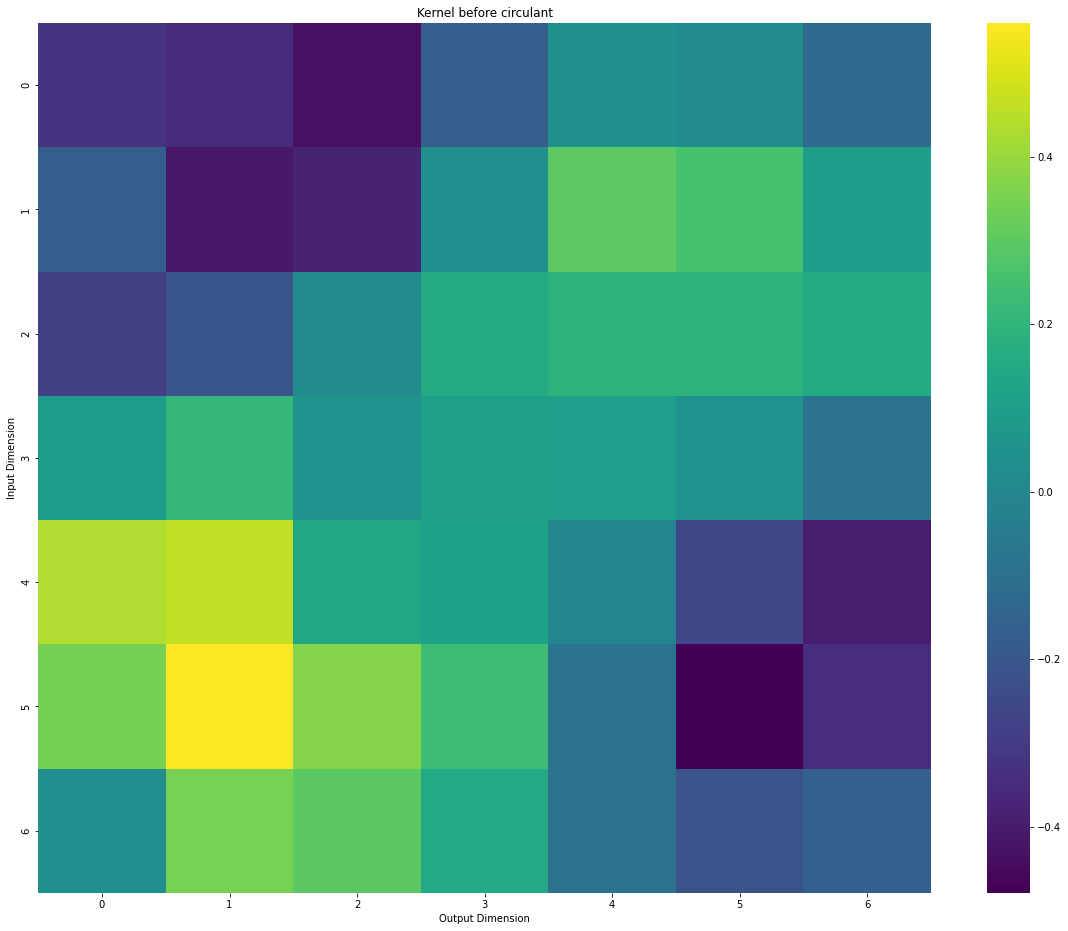

In [82]:
visualize_combined_matrix(kernel_matrix, title="Kernel before circulant")

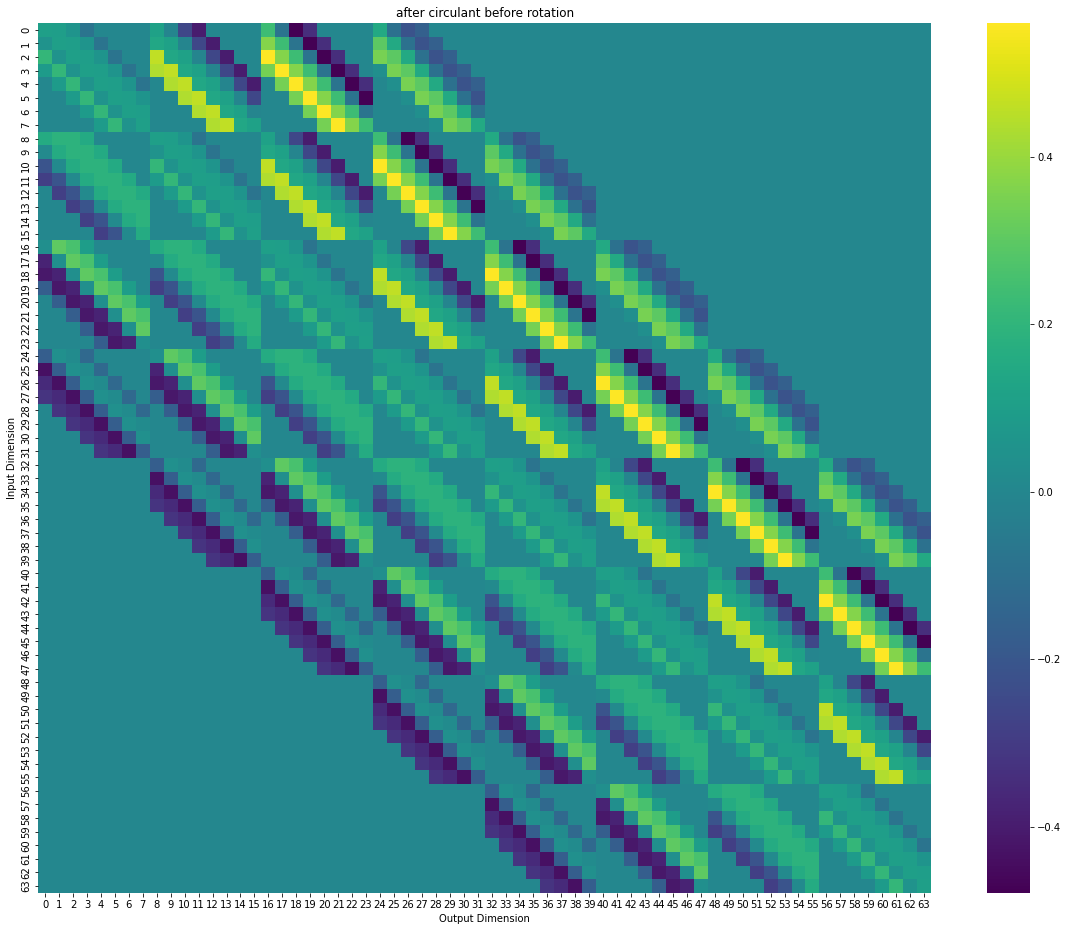

In [83]:
visualize_combined_matrix(
    kernel_circulant_matrix, title="after circulant before rotation"
)

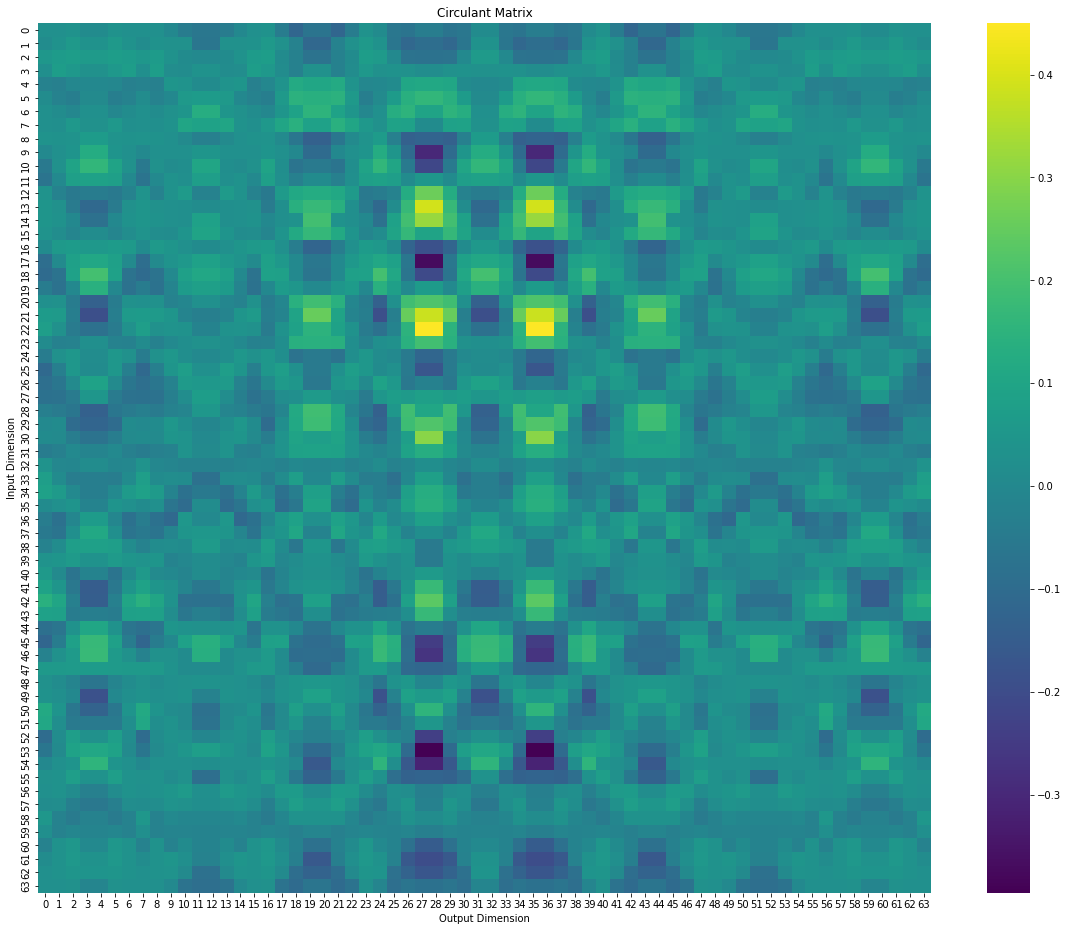

In [84]:
visualize_combined_matrix(averaged_circulant_kernel, title="Circulant Matrix")

In [85]:
X_test[:10].shape

(10, 8, 8, 1)

In [86]:
dummy_test = tf.convert_to_tensor(X_test[:5], dtype=tf.float32)
# for i in range(10):
#     dummy_test = tf.convert_to_tensor(X_test[i : i + 1], dtype=tf.float32)
#     res = np.allclose(
#         tf.map_fn(
#             convolved_3,
#             dummy_test,
#             fn_output_signature=tf.float32,
#         ),
#         tf.map_fn(
#             convolved_3,
#             apply_transformation_batch(
#                 dummy_test, tf.convert_to_tensor(D4_matrices[-2], dtype=tf.float32)
#             ),
#             fn_output_signature=tf.float32,
#         ),
#     )
#     print(res)

In [87]:
def convolved_3(x):
    operator = tf.reduce_mean(
        tf.stack([kernel_circulant_matrix @ matrix for matrix in tf_d4_matrices], axis=0),
        axis=0,
    )
    return tf.reshape(operator @ tf.reshape(x, (64, 1)), (8, 8, 1))

In [88]:
convolved_results = []
for matrix in tf_d4_matrices:
    matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)
    transformed_inputs = apply_transformation_batch(dummy_test, matrix)
    convolved = tf.nn.conv2d(
        transformed_inputs, model.layers[0].kernel, strides=[1, 1, 1, 1], padding="SAME"
    )
    convolved_results.append(convolved)

convolved_average = tf.reduce_mean(tf.stack(convolved_results), axis=0)

In [89]:
def single_conv_layer(test_data):
    convolved_results = []
    for matrix in tf_d4_matrices:
        matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)
        transformed_inputs = apply_transformation_batch(test_data, matrix)
        convolved = tf.nn.conv2d(
            transformed_inputs,
            model.layers[0].kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        convolved_results.append(convolved)

    convolved_average = tf.reduce_mean(tf.stack(convolved_results), axis=0)
    return convolved_average

In [90]:
test_1 = single_conv_layer(dummy_test)
test_2 = single_conv_layer(
    apply_transformation_batch(
        dummy_test, tf_d4_matrices[-2]
    )
)
np.allclose(test_1, test_2)

True

In [91]:
convolved_results_2 = []
for matrix in tf_d4_matrices:
    transformed_inputs = apply_transformation_batch(dummy_test, matrix)
    convolved_2 = tf.map_fn(
        lambda x: kernel_circulant_matrix @ tf.reshape(x, (64, 1)),
        transformed_inputs,
    )
    convolved_results_2.append(tf.reshape(convolved_2, (-1, 8, 8, 1)))

convolved_average_2 = tf.reduce_mean(tf.stack(convolved_results_2), axis=0)

In [92]:
convolved_average_3 = tf.map_fn(
    convolved_3,
    dummy_test,
    # fn_output_signature=tf.float32,
)

In [93]:
print(np.allclose(convolved_average, convolved_average_2))
print(tf.equal(convolved_average, convolved_average_2))

False
tf.Tensor(
[[[[ True]
   [False]
   [False]
   [False]
   [False]
   [ True]
   [ True]
   [False]]

  [[ True]
   [ True]
   [ True]
   [ True]
   [ True]
   [ True]
   [ True]
   [ True]]

  [[ True]
   [ True]
   [False]
   [False]
   [ True]
   [False]
   [ True]
   [ True]]

  [[False]
   [False]
   [ True]
   [False]
   [ True]
   [ True]
   [False]
   [ True]]

  [[ True]
   [False]
   [False]
   [False]
   [False]
   [False]
   [False]
   [ True]]

  [[False]
   [False]
   [ True]
   [ True]
   [False]
   [ True]
   [ True]
   [ True]]

  [[False]
   [ True]
   [ True]
   [False]
   [False]
   [False]
   [False]
   [False]]

  [[ True]
   [ True]
   [False]
   [ True]
   [ True]
   [ True]
   [ True]
   [ True]]]


 [[[ True]
   [ True]
   [ True]
   [False]
   [False]
   [ True]
   [False]
   [ True]]

  [[ True]
   [False]
   [False]
   [ True]
   [ True]
   [False]
   [False]
   [ True]]

  [[ True]
   [ True]
   [ True]
   [ True]
   [False]
   [ True]
   [ True]
   [

In [94]:
are_equal = tf.reduce_all(tf.equal(convolved_average, convolved_average_2))
max_difference = tf.reduce_max(tf.abs(convolved_average - convolved_average_2))
print(f"Are equal: {are_equal}")
print(f"max difference: {max_difference}")

Are equal: False
max difference: 2.384185791015625e-07


In [95]:
print(np.allclose(np.array(convolved_average), np.array(convolved_average_2)))

False


In [96]:
np.allclose(
    tf.map_fn(
        convolved_3,
        dummy_test,
        fn_output_signature=tf.float32,
    ),
    tf.map_fn(
        convolved_3,
        apply_transformation_batch(
            dummy_test, tf_d4_matrices[-2]
        ),
        fn_output_signature=tf.float32,
    ),
)

False

This is just some code to test circulant matrices and how tf handles conv2d

In [97]:
kernel_width = 5
kernel = np.random.rand(kernel_width, kernel_width)
circ_matrix = create_circulant_matrix(kernel)
print("Circulant Matrix Shape:", circ_matrix.shape)

image = np.random.rand(8, 8)
image_vector = image.flatten()
convolved_vector = circ_matrix @ image_vector

# Reshape the result back to 8x8
convolved_image = convolved_vector.reshape((8, 8))

# TensorFlow convolution for comparison
transformed_inputs = tf.reshape(image, (1, 8, 8, 1))
kernel_tf = tf.reshape(kernel, (kernel_width, kernel_width, 1, 1))
convolved_tf = tf.nn.conv2d(
    transformed_inputs, kernel_tf, strides=[1, 1, 1, 1], padding="SAME"
)

# Extract the result
convolved_tf = tf.squeeze(convolved_tf).numpy()

# Compare results
are_equal = tf.reduce_all(tf.equal(convolved_image, convolved_tf))
max_difference = tf.reduce_max(tf.abs(convolved_image - convolved_tf))
print(f"Are equal: {are_equal}")
print(f"max difference: {max_difference}")

Circulant Matrix Shape: (64, 64)
Are equal: False
max difference: 3.552713678800501e-15


In [98]:
test_image = np.ones((8, 8))
test_kernel = 2 * np.ones((7, 7))
test_image

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

In [99]:
test_image = tf.reshape(test_image, (1, 8, 8, 1))
test_kernel = tf.reshape(test_kernel, (7, 7, 1, 1))

In [100]:
res = tf.nn.conv2d(test_image, test_kernel, strides=[1, 1, 1, 1], padding="SAME")

In [101]:
res = tf.reshape(res, (8, 8))

In [102]:
res

<tf.Tensor: shape=(8, 8), dtype=float64, numpy=
array([[32., 40., 48., 56., 56., 48., 40., 32.],
       [40., 50., 60., 70., 70., 60., 50., 40.],
       [48., 60., 72., 84., 84., 72., 60., 48.],
       [56., 70., 84., 98., 98., 84., 70., 56.],
       [56., 70., 84., 98., 98., 84., 70., 56.],
       [48., 60., 72., 84., 84., 72., 60., 48.],
       [40., 50., 60., 70., 70., 60., 50., 40.],
       [32., 40., 48., 56., 56., 48., 40., 32.]])>

## STEP 2 - COB

We have the averaged_circulant_kernel. Now we get the change of basis matrix:

In [104]:
from sympy.parsing.sympy_parser import parse_expr

with open('8x8COB.txt', 'r') as f:
    Q = [next(f) for _ in range(129)] # f.read()
Q = [parse_expr(s.strip('\n')) for s in Q if s != '\n']
Q = Q[1:] # Remove constant
Q1, Q2, Q3, Q4, Q56, Q78 = Q[:10], Q[10:16], Q[16:22], Q[22:32], Q[32:48], Q[48:]
Q1, Q2, Q3, Q4, Q56, Q78 = [elem[0,0] for elem in Q1], [elem[1,0] for elem in Q2], [elem[2,0] for elem in Q3], [elem[3,0] for elem in Q4], [elem[(4,5),0].tolist() for elem in Q56], [elem[(6,7),0].tolist() for elem in Q78]

In [105]:
import re
Q1_Str = [[elem.replace('x','') for elem in l] for l in [str(q).split(' + ') for q in Q1]]
Q2_str = [str(q).replace(' - ',' + -') for q in Q2]
Q2_Str = [[elem.replace('x','') for elem in l] for l in [str(q).split(' + ') for q in Q2_str]]
Q3_str = [str(q).replace(' - ',' + -') for q in Q3]
Q3_Str = [[elem.replace('x','') for elem in l] for l in [str(q).split(' + ') for q in Q3_str]]
Q4_str = [str(q).replace(' - ',' + -') for q in Q4]
Q4_Str = [[elem.replace('x','') for elem in l] for l in [str(q).split(' + ') for q in Q4_str]]
Q56_str = [(str(q[0]).replace(' - ',' + -'),str(q[1]).replace(' - ',' + -')) for q in Q56]
Q56_Str = [[[elem.replace('x','').replace('[','').replace(']','') for elem in l0],[elem.replace('x','').replace('[','').replace(']','') for elem in l1]] for l0,l1 in [(q[0].split(' + '),q[1].split(' + ')) for q in Q56_str]]

In [106]:
from math import copysign

X_matrix = jnp.zeros((64,64))

Q1_to_4 = Q1_Str + Q2_Str + Q3_Str + Q4_Str

for i in range(32):
  for elem in Q1_to_4[i]:
    X_matrix = X_matrix.at[i,abs(int(elem))-1].set(np.sign(int(elem))*1)

for i in range(16):
  for elem in Q56_Str[i][0]:
    X_matrix = X_matrix.at[i+32,abs(int(elem))-1].set(np.sign(int(elem))*1)
  for elem in Q56_Str[i][1]:
    X_matrix = X_matrix.at[i+48,abs(int(elem))-1].set(np.sign(int(elem))*1)

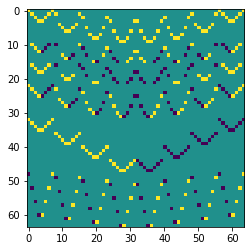

In [107]:
B = X_matrix.copy()
plt.imshow(B)

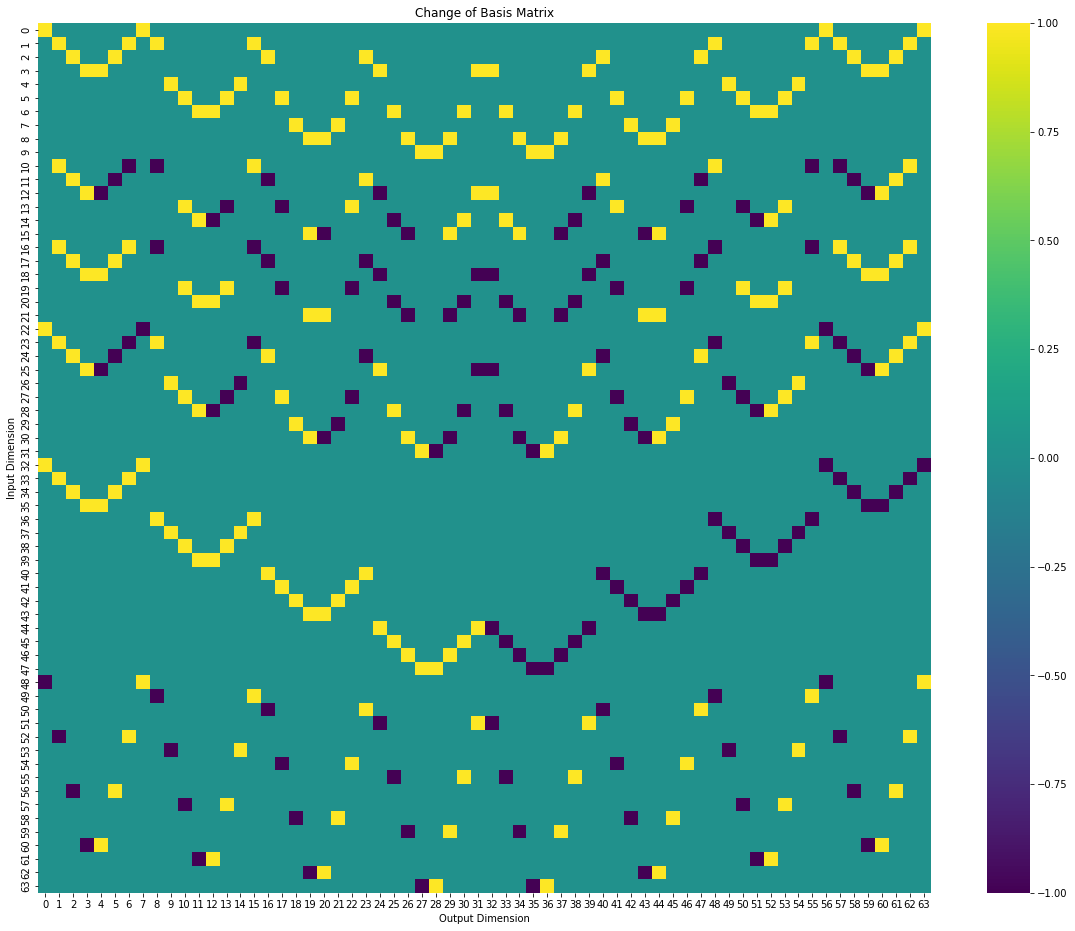

In [114]:
visualize_combined_matrix(B, title="Change of Basis Matrix")

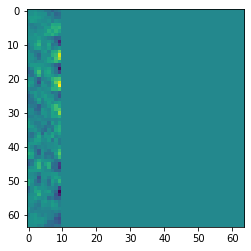

In [108]:
B = np.array(B)
B_inv = np.linalg.inv(B)
M = averaged_circulant_kernel @ B_inv

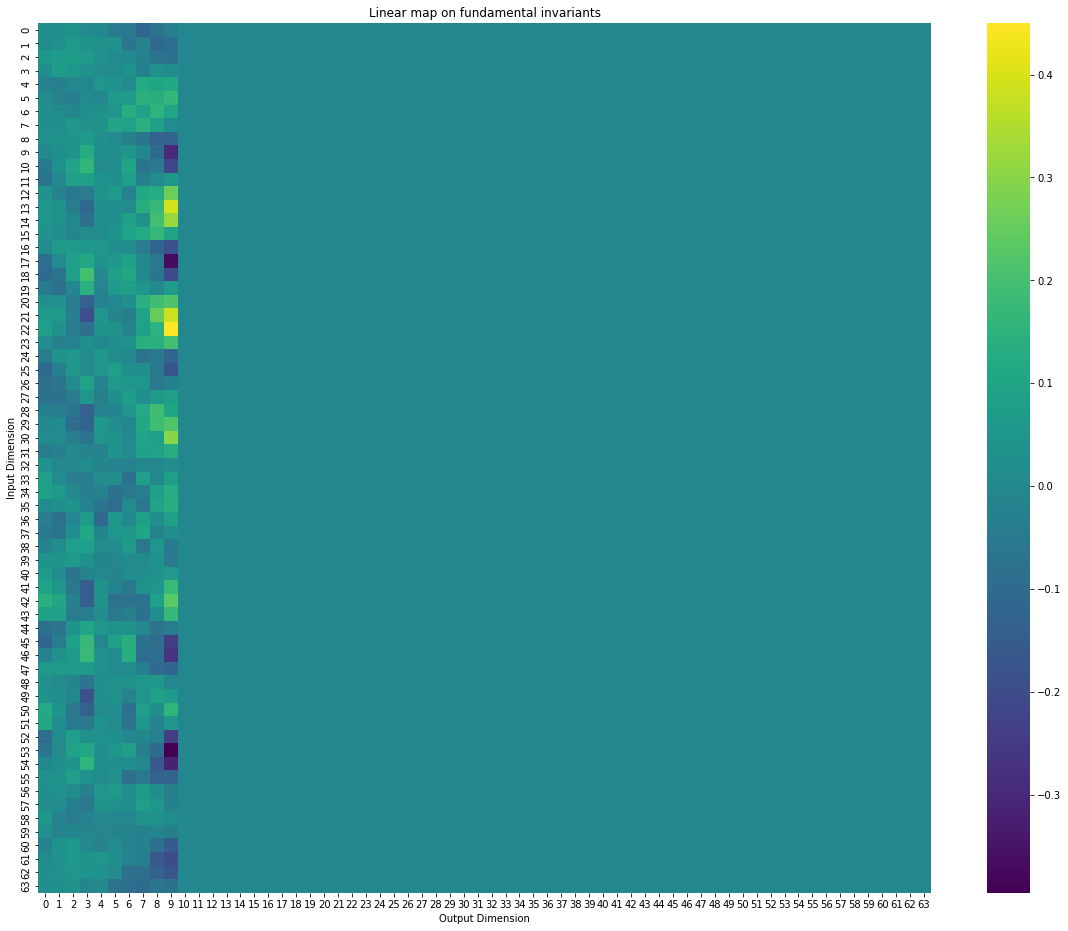

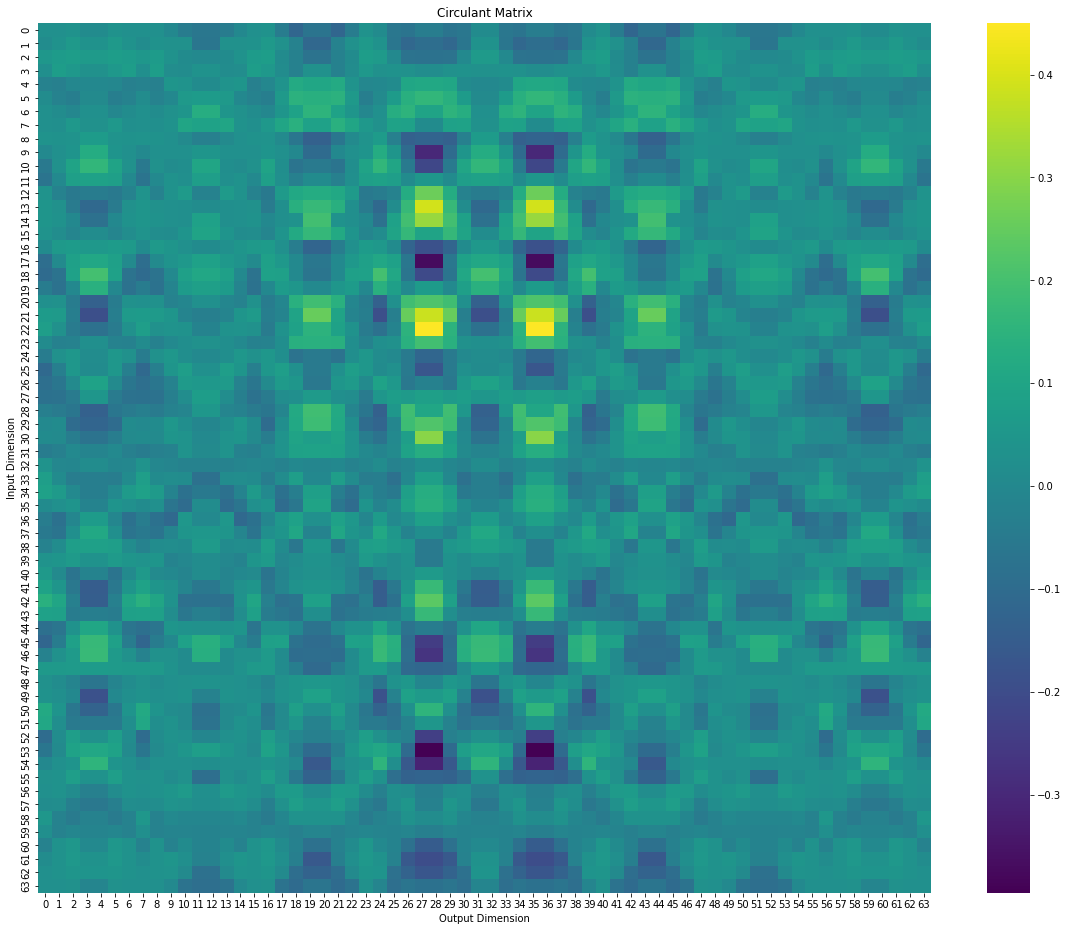

In [115]:
visualize_combined_matrix(M, title="Linear map on fundamental invariants")
visualize_combined_matrix(averaged_circulant_kernel, title="Circulant Matrix")